In [1]:
from datetime import datetime
import numpy as np
from cpuinfo import get_cpu_info
from Tools.PlotTools import VisualTool
from Tools.MapLoader import MapLoader
from Tools.Mask import layer_map

In [ ]:
vis=VisualTool(show=True, size=(5,5), save=False)
map=MapLoader().load("seocho.full")

### Overview of Construction site map

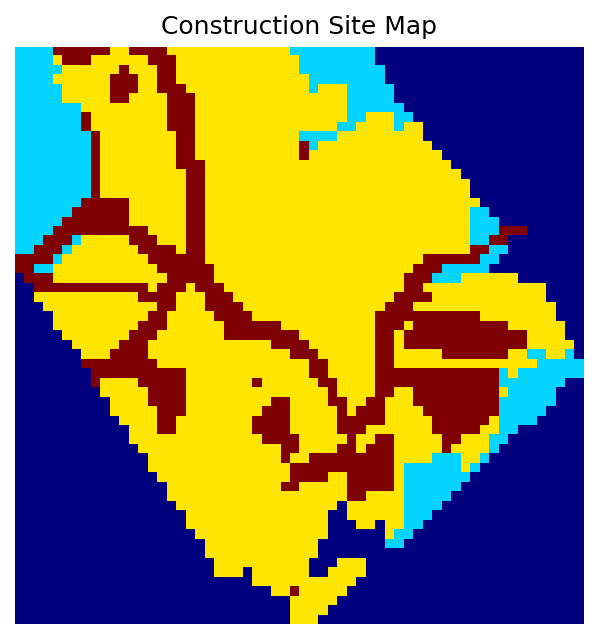

In [3]:
vis.showJetMap(map_data=map, title="Construction Site Map")

Installable map
<br><sub> A binary grid mask that defines physically feasible sensor deployment locations on the site. </sub>

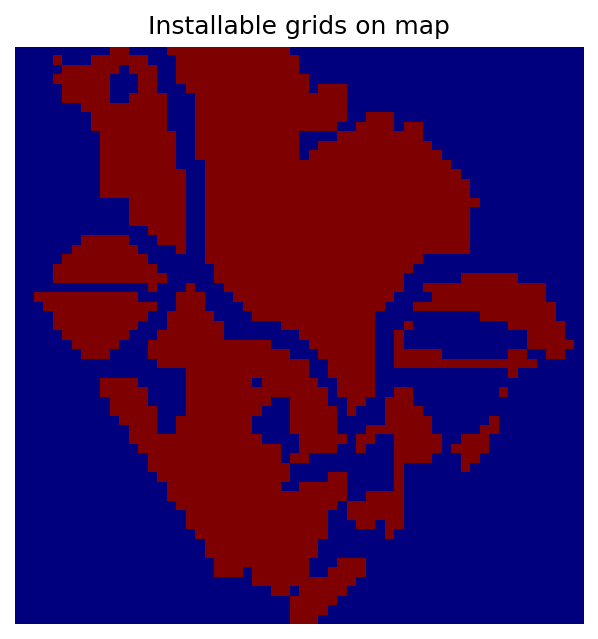

In [4]:
installable_layer = layer_map(map, keep_values=[2])
vis.showJetMap(map_data=installable_layer, title="Installable grids on map")

Uninstallable map
<br><sub>Regions excluded from sensor deployment due to safety, accessibility, or operational constraints <br>(e.g., equipment routes, waterlogged areas, vegetation, and offices).</sub>

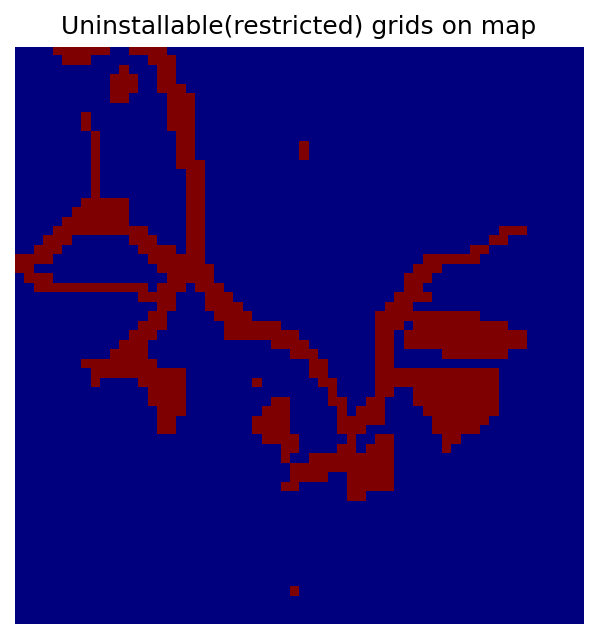

In [5]:
road_layer = layer_map(map, keep_values=[3])
vis.showJetMap(map_data=road_layer, title="Uninstallable(restricted) grids on map")

Jobsite area
<br><sub>The coverage target area for sensor deployment, defined as the union of installable and non-installable regions.</sub>

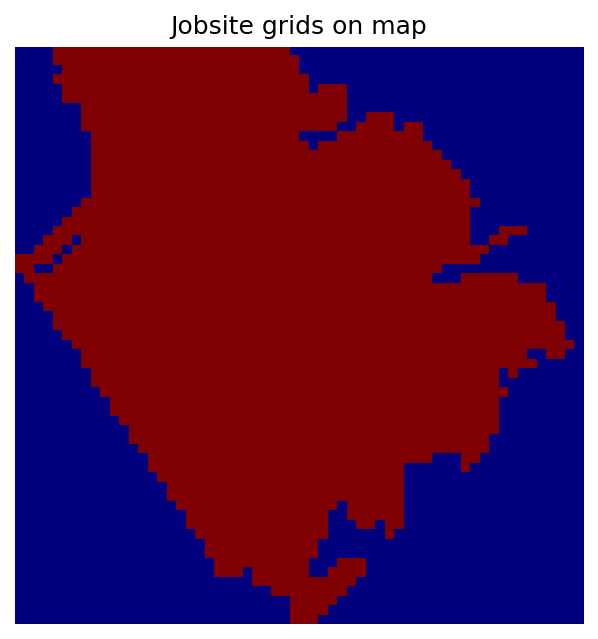

In [6]:
jobsite_layer = layer_map(map, keep_values=[2,3])
vis.showJetMap(map_data=jobsite_layer, title="Jobsite grids on map")

### Systematic sensor deployment

In [7]:
#Set sensor coverage radius
COVERAGE = 45

Outermost corner location candidate extraction
<br><sub> Detection of outermost feasible sensor placement candidates within installable regions, since environmental sensing modules must be deployed at the site boundaries to capture extreme conditions. </sub>

Outmost corner points: 9


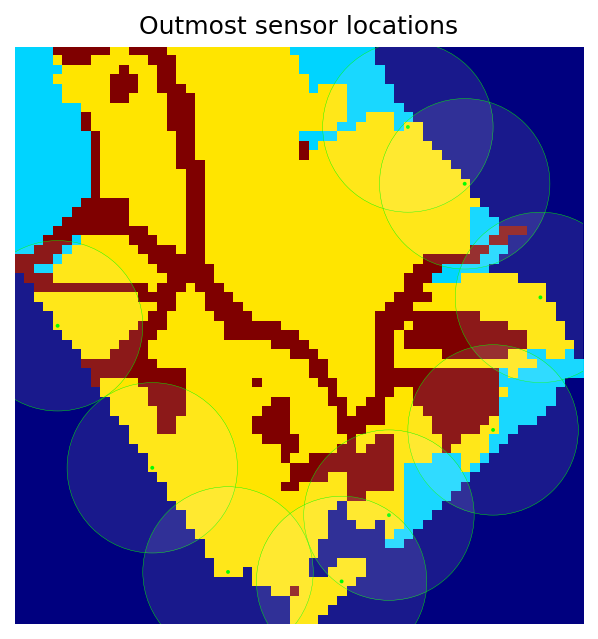

In [8]:
from OuterDeployment.HarrisCorner import HarrisCorner

corner_layer = HarrisCorner(jobsite_layer)
corner_candidate = corner_layer.run(
    grid=jobsite_layer,                
    installable_layer=installable_layer, 
    blockSize=3,
    ksize=3,
    k=0.01,
    dilate_size=5,
    min_dist=5,
)

print("Outmost corner points:", len(corner_candidate))
vis.showJetMap_circle(map_data=map, sensor_positions=corner_candidate, title="Outmost sensor locations",radius=COVERAGE)

Inner-Deployment Strategy: Genetic Algorithm
<br><sub>Genetic Algorithm is used to optimize the placement of inner sensors, minimizing the number of sensors while ensuring sufficient coverage of the jobsite area. </sub>

In [9]:
from InnerDeployment.GeneticAlgorithm.main import SensorGA

ga = SensorGA(
                installable_map=installable_layer,
                jobsite_map=jobsite_layer,
                coverage=COVERAGE,
                generations=100,
                corner_positions=corner_candidate,
                initial_size=100,
                selection_size=50,
                child_chromo_size=100,
                min_sensors=50,
                max_sensors=100,
            )

optimized_result = ga.run(
                    selection_method="tournament",
                    mutation_rate=0.7,
                    early_stop=True,
                    early_stop_coverage=90.0,
                    early_stop_patience=5,
                    return_best_only=True
                )

[Gen:001/100] Fitness : (best=100.0000, avg=99.9153, worst=98.8802) | Coverage(best)=100.00% | Numb of sensors : (min=20, avg=22.9, max=26) | BestSensors=23 (corner=9)
[Profile Gen 001] fitness=56.141s | selection=0.000s | repro=0.454s (crossover=0.244s, mutation=0.209s) | calls: crossover~100, mutation~70.0
               fitness_breakdown: ordering=8.103s | score=48.035s | pop=100 

[Gen:002/100] Fitness : (best=100.0000, avg=93.9576, worst=86.1246) | Coverage(best)=100.00% | Numb of sensors : (min=17, avg=20.0, max=24) | BestSensors=22 (corner=9)
[Profile Gen 002] fitness=4.058s | selection=0.000s | repro=0.322s (crossover=0.157s, mutation=0.165s) | calls: crossover~100, mutation~70.0
               fitness_breakdown: ordering=0.510s | score=3.546s | pop=100 

[Gen:003/100] Fitness : (best=97.7118, avg=90.7045, worst=76.7283) | Coverage(best)=97.71% | Numb of sensors : (min=16, avg=18.6, max=22) | BestSensors=19 (corner=9)
[Profile Gen 003] fitness=3.113s | selection=0.000s | repro=

In [10]:
print("[FINALIZE OUTPUT] ga.best_solution =", ga.best_solution)
print("[FINALIZE OUTPUT] len(ga.best_solution) =", len(ga.best_solution))
print("[FINALIZE OUTPUT] ga.corner_points =", ga.corner_points)
print("[FINALIZE OUTPUT] len(ga.corner_points) =", len(ga.corner_points))

[FINALIZE OUTPUT] ga.best_solution = [(23, 24), (21, 6), (36, 31), (12, 11), (26, 37), (34, 18), (13, 24), (8, 4), (41, 32), (27, 8), (11, 35), (29, 40), (9, 21), (42, 27)]
[FINALIZE OUTPUT] len(ga.best_solution) = 14
[FINALIZE OUTPUT] ga.corner_points = [(41, 8), (47, 14), (55, 26), (4, 29), (50, 40), (14, 44), (39, 49), (22, 55), (34, 56)]
[FINALIZE OUTPUT] len(ga.corner_points) = 9


Total number of Sensor : 23


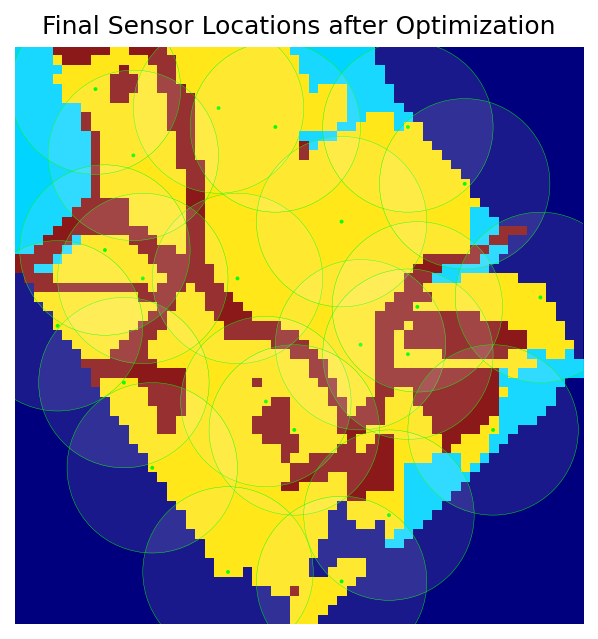

In [12]:
final_result = optimized_result + corner_candidate
print("Total number of Sensor :", len(final_result))
vis.showJetMap_circle(
    map_data=map, 
    sensor_positions=final_result,
    title="Final Sensor Locations after Optimization",
    radius=COVERAGE
    )